In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from PIL import Image
from typing import List, Tuple
import copy
import random

import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2.5.1+cu118
11.8
True
Using device: cuda


## Dataset

In [3]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split # used for splitting the dataset in train and test
        self.paths, self.labels = self.read_file() #reading the labels and images

        self.transform = transform 

    def __len__(self) -> int: #get the number of elements in the dataset
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]: 
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    # legge un file di testo che contiene i percorsi delle immagini e le etichette associate
    # restituisce due liste: una con percorsi delle immagini e una con le etichette
    def read_file(self) -> Tuple[List[str], List[int]]: #outputs a tuple
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ") #rimuove il carattere di nuova linea, e poi divide in 3 parti con virgola come separatore 
                paths.append(path), labels.append(int(label)) #salva solo percorsi ed etichette

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=mean, std=std),
])

In [5]:
train_dataset = GroceryStoreDataset(split="train", transform=transform)
test_dataset = GroceryStoreDataset(split="test", transform=transform)
val_dataset = GroceryStoreDataset(split="val", transform=transform)

In [6]:
def get_class_distribution(dataset):
    labels = [label for _, label in dataset]
    distribution = Counter(labels)
    return distribution

train_distribution = get_class_distribution(train_dataset)
test_distribution = get_class_distribution(test_dataset)
val_distribution = get_class_distribution(val_dataset)

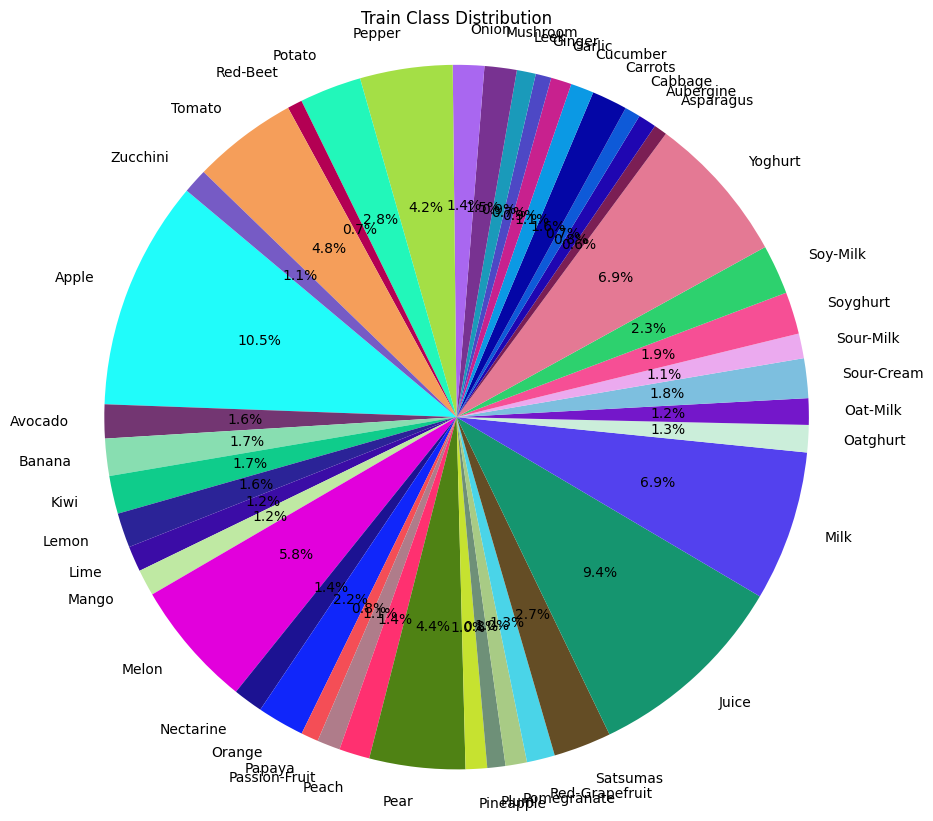

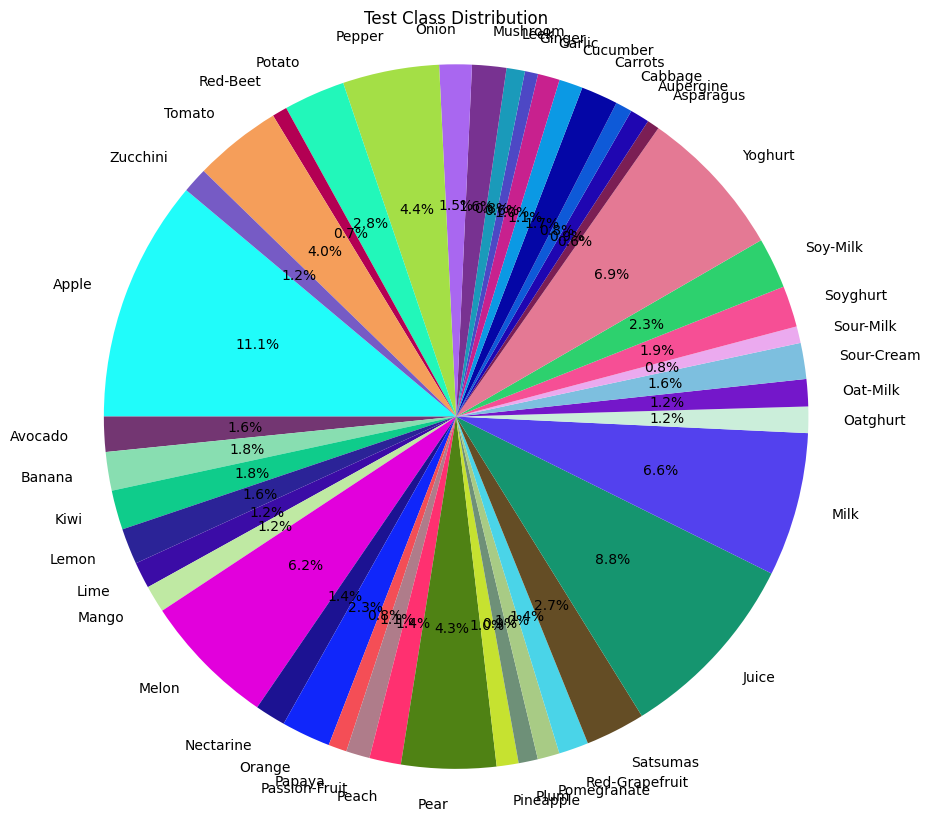

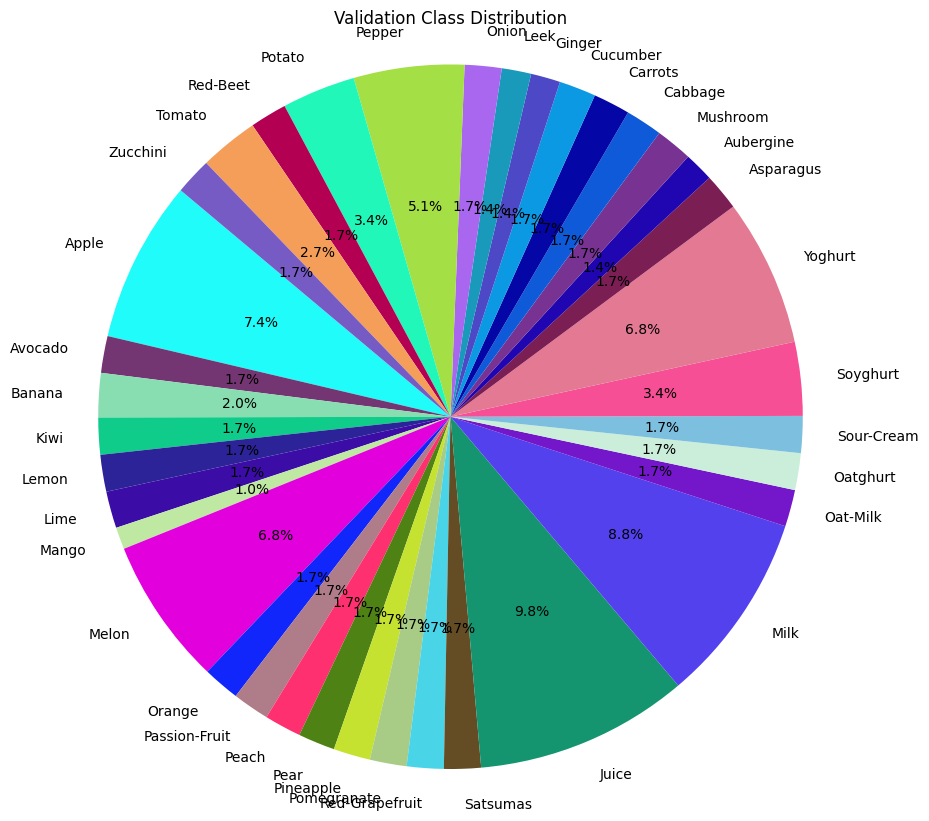

In [7]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Class labels mapping
CLASS_NAMES = [
    "Apple", "Avocado", "Banana", "Kiwi", "Lemon", "Lime", "Mango", "Melon", "Nectarine", 
    "Orange", "Papaya", "Passion-Fruit", "Peach", "Pear", "Pineapple", "Plum", "Pomegranate", 
    "Red-Grapefruit", "Satsumas", "Juice", "Milk", "Oatghurt", "Oat-Milk", "Sour-Cream", 
    "Sour-Milk", "Soyghurt", "Soy-Milk", "Yoghurt", "Asparagus", "Aubergine", "Cabbage", 
    "Carrots", "Cucumber", "Garlic", "Ginger", "Leek", "Mushroom", "Onion", "Pepper", "Potato", 
    "Red-Beet", "Tomato", "Zucchini"
]

# Pre-generate consistent colors for each class
def generate_class_colors():
    np.random.seed(42)  # Ensure reproducibility
    colors = [f"#{random.randint(0, 0xFFFFFF):06x}" for _ in CLASS_NAMES]
    return colors

# Create a dictionary of class indices and their corresponding colors
CLASS_COLORS = generate_class_colors()

def plot_class_distribution_pie(distribution, title):
    class_indices = list(distribution.keys())
    class_counts = list(distribution.values())
    class_labels = [CLASS_NAMES[idx] for idx in class_indices]
    colors = [CLASS_COLORS[idx] for idx in class_indices]
    
    # Plotting the pie chart
    plt.figure(figsize=(10, 10))
    plt.pie(class_counts, labels=class_labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Example usage
plot_class_distribution_pie(train_distribution, "Train Class Distribution")
plot_class_distribution_pie(test_distribution, "Test Class Distribution")
plot_class_distribution_pie(val_distribution, "Validation Class Distribution")


In [ ]:
def calculate_mean_std(dataloader):
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in dataloader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

# Calculate mean and std
mean, std = calculate_mean_std(train_loader)

print(f"Mean: {mean}") 
print(f"Std: {std}")

https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch

 The first layer of a CNN is always a convolutional layer. A convolutional layer applies a filter (or kernel) to the input, and passes the result to the next layer. The filter is usually smaller that the image (most often, we can find 3x3 or 5x5 filters), and it moves across the image from top left to bottom right, detecting different features and simplifying the image before passing it onto the next layer. With each convolutional layer, we have to use an activation function. ReLU is a linear function that became the default activation function for many types of neural networks, because it makes the model easy to train, doesn‘t get the vanishing gradient problem compared to Sigmoid and TanH, and often achieves better results.

Conv2D

There are many different types of convolutional layers, but 2D Convolution Layer (Conv2D) is the most common one. The filter "slides" over the 2D input data and multiplies each pixel. As a result, it sums up everything to a single output pixel.

Input shape

As input, CNN takes tensors of shape (image_height, image_width, color_channels). For color images, color channels are RGB (red, green, blue). The format of CIFAR images is (32, 32, 3), so that‘s what we will pass to the CNN.


**kernel_size**

- specifica la dimensione della finestra del filtro che viene applicata all'immagine durante l'operazione di convoluzione
- se kernel_size=3 allora il filtro sarà una matrice 3x3
- un kernel grande cattura più contesto dell'immaigne ma aumenta anche il numero di parametri e il costo computazionale 

**stride**
- specifica di quanti pixel il filtro si sposta o striscia (?) sull'immagine durante l'operazione di convoluzione
- se stride=1 si sposta di un pixel alla volta, se stride=2 di due pixel alla volta e così via 
- un stride maggiore riduce la dimensione spaziale dell'output poichè il filtro copre meno posizioni sull'immagine

**padding**
- aggiunge pixel extra (tipicamente con valore zero) attorno ai bordi dell'immagine prima di applicare la convoluzione
- se padding=1 viene aggiunto un bordo di un pixel attorno all'immagine
- aiuta a preservare la dimensione spaziale dell'immagine dopo la convoluzione, senza la dimensione dell'immagine si riduce ad ogni convoluzione

**MaxPooling (MaxPool2d)**

Il layer di Max Pooling (MaxPool2d in PyTorch) è utilizzato nelle reti neurali convoluzionali (CNN) per ridurre la dimensione spaziale (altezza e larghezza) dell'input (che porta a una riduzione del numero di parametri e del costo computazionale nei layer successivi), mantenendo le caratteristiche più importanti (seleziona il valore massimo in ogni finestra del kernel). Questo processo è noto come "downsampling". Utile anche per la riduzione di overfitting. 
Gli strati di maxpooling tipicamente vengono aggiunti dopo ogni convolutional layer insieme a un layer relu

# Simple cnn 

`SimpleCNN` is a simple convolutional neural network (CNN) implemented using PyTorch. The network consists of two convolutional layers followed by three fully connected layers.

The `forward` function defines the data flow through the network, applying ReLU activation functions after each convolutional and fully connected layer, and using max pooling after each convolutional layer.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 53 * 53, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

s_cnn = SimpleCNN()
s_cnn.to(device)
summary(s_cnn, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

# MID CNN

In [ ]:
class MidCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(MidCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self._to_linear = None
        self.convs(torch.randn(1, 3, 224, 224))
        
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
        self.dropout = nn.Dropout(0.5)

    def convs(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        if self._to_linear is None:
            self._to_linear = x.view(-1).shape[0]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
mid_cnn= MidCNN()
mid_cnn.to(device)
summary(mid_cnn, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

# CNN 2

In [ ]:
class CNN_2(nn.Module):
    def __init__(self, num_classes=43):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(64*56*56, 128)
        self.relu1 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.dropout1(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu1(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu1(out)
        out = self.pool2(out)
        out = self.dropout2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropout3(out)
        out = self.fc2(out)
        return out

cnn_2 = CNN_2()
cnn_2.to(device)
summary(cnn_2, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, patience):
    # Loss function
    loss_fn = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
    # Scheduler
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    best_acc = 0.0
    early_stop_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):

        # Initialize metrics for this epoch
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Save losses and accuracies
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        # Deep copy the model if validation accuracy improves
        if epoch_val_loss <= best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Update best validation accuracy
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

        # Step the scheduler
        scheduler.step()

    print(f'Best val accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
def evaluate_model(model, dataloader):
	# Loss function
	criterion = nn.CrossEntropyLoss()

	# Set model to evaluation mode
	model.eval()
	test_running_loss = 0.0
	correct = 0
	total = 0

	# Disable gradient computation
	with torch.no_grad():
		for images, labels in dataloader:
			images, labels = images.to(device), labels.to(device)

			outputs = model(images)
			loss = criterion(outputs, labels)
			test_running_loss += loss.item() * images.size(0)

			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
	
	# Calculate average loss and accuracy
	test_loss = test_running_loss / len(test_loader.dataset)
	test_accuracy = 100 * correct / total
	
	# Print metrics
	print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")